In [1]:
print(2251262659%15+1)

5


In [3]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.1 MB/s eta 0:00:00


In [10]:
df = pd.read_csv('/content/climate_change.csv')
df.head()

,Year,Month,MEI,CO2,CH4,N2O,CFC-11,CFC-12,TSI,Aerosols,Temp
0,1983,5,2.556,345.96,1638.59,303.677,191.324,350.113,1366.1024,0.0863,0.109
1,1983,6,2.167,345.52,1633.71,303.746,192.057,351.848,1366.1208,0.0794,0.118
2,1983,7,1.741,344.15,1633.22,303.795,192.818,353.725,1366.2850,0.0731,0.137
3,1983,8,1.130,342.25,1631.35,303.839,193.602,355.633,1366.4202,0.0673,0.176
4,1983,9,0.428,340.17,1648.40,303.901,194.392,357.465,1366.2335,0.0619,0.149


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from hmmlearn.hmm import GaussianHMM

# Đọc dữ liệu
df = pd.read_csv('/content/climate_change.csv')
df.head()
# Chọn biến cần phân tích
features = ['MEI', 'CO2', 'CH4', 'N2O', 'CFC-11', 'CFC-12', 'TSI', 'Aerosols']
target = 'Temp'

# Chuẩn hóa dữ liệu đầu vào
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Target (nhiệt độ)
y = df[target].values

# Trục thời gian (Year + Month)
t = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))

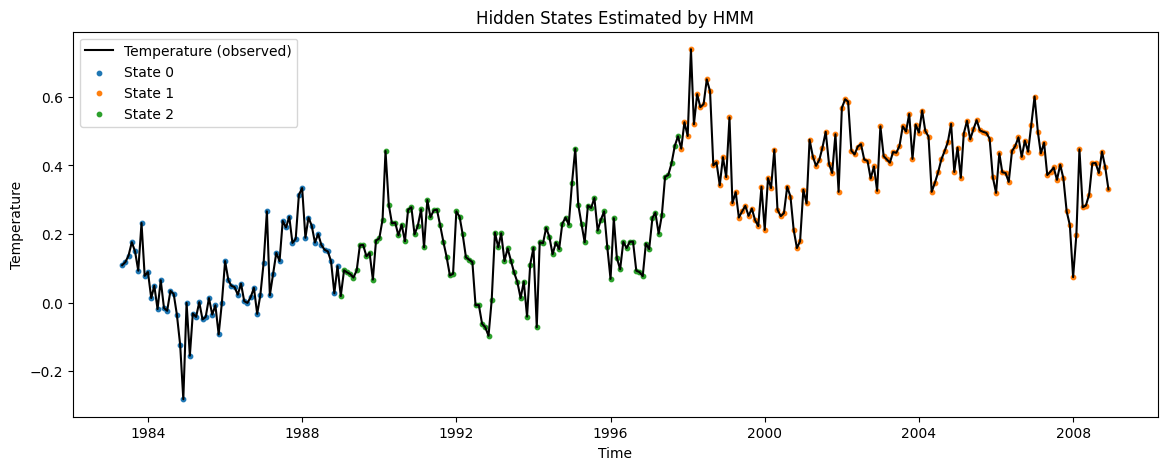

In [5]:
# HMM: Tìm trạng thái ẩn
n_states = 3
hmm_model = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
hmm_model.fit(X_scaled)

# Dự đoán chuỗi trạng thái ẩn
hidden_states = hmm_model.predict(X_scaled)

# Visualize states over time
plt.figure(figsize=(14,5))
plt.plot(t, y, label='Temperature (observed)', color='black')
for state in range(n_states):
    plt.scatter(t[hidden_states == state], y[hidden_states == state], label=f'State {state}', s=10)
plt.title('Hidden States Estimated by HMM')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()


In [6]:
# Gaussian Process cho mỗi trạng thái
gp_models = []
predictions = np.zeros_like(y)

time_index = np.arange(len(t)).reshape(-1, 1)  # dùng index làm input cho GP

for state in range(n_states):
    idx = hidden_states == state
    if np.sum(idx) < 3:
        continue  # tránh lỗi với trạng thái quá ít điểm

    # Lấy dữ liệu cho state này
    X_state = time_index[idx]
    y_state = y[idx]

    # Kernel: RBF + noise
    kernel = 1.0 * RBF(length_scale=10.0) + WhiteKernel(noise_level=0.1)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True)
    gp.fit(X_state, y_state)

    # Dự đoán toàn bộ tập dữ liệu với GP của state này
    y_pred, y_std = gp.predict(time_index, return_std=True)

    # Kết hợp theo xác suất trạng thái từ HMM (soft assignment)
    predictions += y_pred * hmm_model.predict_proba(X_scaled)[:, state]

    gp_models.append(gp)


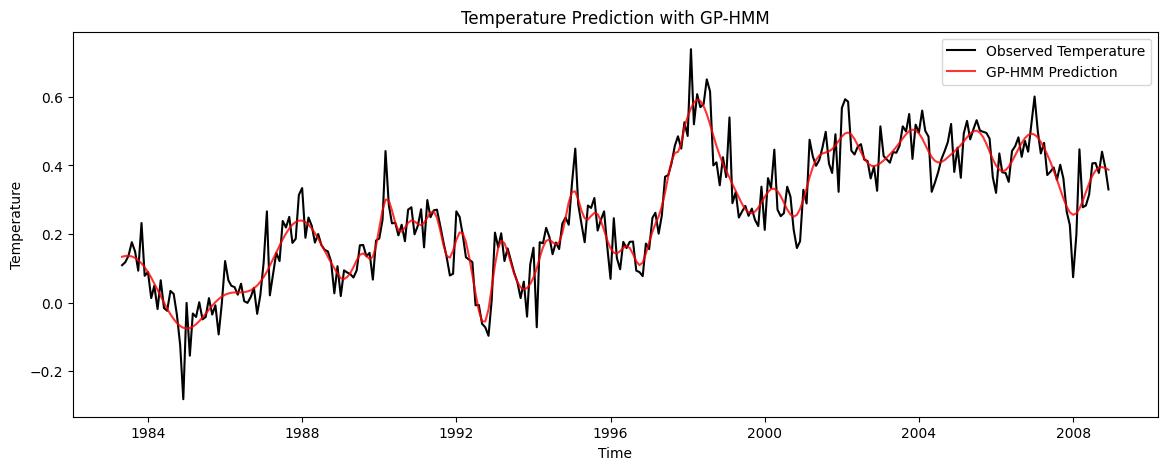

In [7]:
plt.figure(figsize=(14,5))
plt.plot(t, y, 'k', label='Observed Temperature')
plt.plot(t, predictions, 'r', label='GP-HMM Prediction', alpha=0.8)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Prediction with GP-HMM')
plt.legend()
plt.show()
